<a href="https://colab.research.google.com/github/ZJEEE/Long-Term-PEMFC-DL-Prognostics/blob/main/PEMFC_Prognostics_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Author: Kartik Sahajpal
# Licensed under MIT License

# Requirements

In [38]:
# Install required libraries
!pip install optuna
!pip install tensorflow
!pip install statsmodels
!pip install plotly

In [3]:
# Check Available GPUs
!nvidia-smi
!cat /proc/meminfo

Mon Feb 24 06:46:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Import required libraries
import optuna
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error
import tensorflow as tf
#%tensorflow_version 2.9
from tensorflow import keras, data
from random import random
# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 600
# print(tf.__version__)

In [5]:
# Set Random Seeds to Get Reproducible Results
seed_value = 0

# Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Set column display limit if needed
from google.colab.data_table import DataTable
DataTable.max_columns = 30

# Load the IEEE 2014 PHM Data Challenge Dataset

In [8]:
# IEEE PHM 2014 Data Challenge Dataset without ripples
df_part1 = pd.read_csv(r'/content/drive/MyDrive/IEEE2014DataChallengeData/FC1_Without_Ripples/FC1_Ageing_part1.csv', encoding = "ISO-8859-1")
df_part2 = pd.read_csv(r'/content/drive/MyDrive/IEEE2014DataChallengeData/FC1_Without_Ripples/FC1_Ageing_part2.csv', encoding = "ISO-8859-1")
df_part3 = pd.read_csv(r'/content/drive/MyDrive/IEEE2014DataChallengeData/FC1_Without_Ripples/FC1_Ageing_part3.csv', encoding = "ISO-8859-1")
frames = [df_part1, df_part2, df_part3]
phm_dataset_1 = pd.concat(frames, ignore_index = True).astype('float32')
# Elucidate statistical features
# phm_dataset_1.describe().transpose()
# Plot stack voltage as a function of time
# plt.plot(list(phm_dataset['Time (h)']), list(phm_dataset['Utot (V)']))

In [9]:
# IEEE PHM 2014 Data Challenge Dataset with ripples
df_part1 = pd.read_csv(r'/content/drive/MyDrive/IEEE2014DataChallengeData/Full_FC2_With_Ripples/FC2_Ageing_part1.csv', encoding = "ISO-8859-1")
df_part2 = pd.read_csv(r'/content/drive/MyDrive/IEEE2014DataChallengeData/Full_FC2_With_Ripples/FC2_Ageing_part2.csv', encoding = "ISO-8859-1")
phm_dataset_2 = pd.concat([df_part1, df_part2], ignore_index = True).dropna(axis=1, how='all').astype('float32')
# Elucidate statistical features
# phm_dataset_2.describe().transpose()
# Plot stack voltage as a function of time
# plt.plot(list(phm_dataset_2['Time (h)']), list(phm_dataset_2['Utot (V)']))

In [10]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
	"""
  Multivariate Time Series
  Convert series to supervised learning
  Standard practice in time series forecasting to use lagged observations (e.g. t-1) as input variables to forecast the current time step (t)
  Code sourced from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = pd.concat(cols, axis = 1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace = True)
	return agg

# Model Implementation

In [11]:
BATCH_SIZE = 72
class Neural_Networks():
    """
    Implements structure, training, and validation of neural network models.
    """
    def __init__(self, x_train, y_train, x_valid, y_valid, x_test, y_test, volt_scaler) -> None:
        """
        volt_scaler is the MinMaxScaler object used to normalize Utot(V) in range (0,1)
        """
        self.mae = keras.losses.MeanAbsoluteError()
        self.x_train, self.y_train = x_train, y_train  # Training set
        self.x_valid, self.y_valid = x_valid, y_valid # Validation set
        self.x_test, self.y_test = x_test, y_test   # Test set
        self.volt_scaler = volt_scaler
        # Hyperparameter tuning results for static loading dataset with 50% data as training set
        # stored as attributes for easy accessibility
        self.opt_LSTM_units, self.opt_GRU_units = 75, 92
        self.opt_LSTM_LR, self.opt_GRU_LR = 0.00045967464871265887, 0.0006899549137745159 #Adam
        self.opt_LSTM_dropout, self.opt_GRU_dropout = 0.10204101575985941, 0.06017063859125542
        self.opt_CNN_LSTM_units, self.opt_CNN_GRU_units = 108, 102
        self.opt_CNN_LSTM_filters, self.opt_CNN_GRU_filters = 93, 97
        self.opt_CNN_LSTM_LR, self.opt_CNN_GRU_LR = 0.00039458365054797465, 0.0005623902764462512 #Adam
        self.opt_CNN_LSTM_dropout, self.opt_CNN_GRU_dropout = 0.21587038777591175, 0.06863870820110385
        self.opt_CNN_BidirLSTM_units, self.opt_CNN_BidirGRU_units = 100, 71
        self.opt_CNN_BidirLSTM_filters, self.opt_CNN_BidirGRU_filters = 79, 95
        self.opt_CNN_BidirLSTM_LR, self.opt_CNN_BidirGRU_LR = 0.0001415542408060021, 0.00011281449394542564 #Adam
        self.opt_CNN_BidirLSTM_dropout, self.opt_CNN_BidirGRU_dropout = 0.311649235809069, 0.22507334379858374


    def build_LSTM_model(self, hidden_neurons, activator, drop_out, optimizer):
        """
        LSTM Network.
        Use bidir_LSTM_layer in keras.Sequential() to implement a Bidirectional LSTM.
        """
        keras.backend.clear_session()
        output_neurons = 1
        LSTM_layer = keras.layers.LSTM(hidden_neurons, input_shape = (self.x_train.shape[1], self.x_train.shape[2]),
                dropout = drop_out, activation = activator)
        # For bidirectional LSTM, move input_shape argument from LSTM layer to Bidirectional
        # bidir_LSTM_layer = keras.layers.Bidirectional(LSTM_layer)
        # Dropout added as validation loss increasing => DNN Overfitting
        output_layer = keras.layers.Dense(output_neurons)
        lstm_model = keras.Sequential(layers = (LSTM_layer, output_layer))
        lstm_model.reset_states()
        lstm_model.compile(optimizer = optimizer, loss = self.mae)
        lstm_model.summary()
        return lstm_model


    def build_GRU_model(self, hidden_neurons, activator, drop_out, OPTIMIZER = 'adam'):
        """
        GRU Network.
        Default OPTIMIZER used when not supplied.
        """
        keras.backend.clear_session()
        output_neurons = 1
        GRU_layer = keras.layers.GRU(hidden_neurons, dropout = drop_out, activation = activator)
        gru_model = keras.Sequential(layers = (GRU_layer, keras.layers.Dense(output_neurons)))
        gru_model.reset_states()
        gru_model.compile(optimizer = OPTIMIZER, loss = self.mae)
        return gru_model


    def build_CNN_LSTM_model(self, hidden_neurons, activator_CNN, drop_out, filters = 64, OPTIMIZER = 'adam', activator_LSTM = 'tanh'):
        """
        LSTM-CNN Network.
        Default values of filters, OPTIMIZER, activator_LSTM used when not supplied.
        """
        keras.backend.clear_session()
        output_neurons = 1
        LSTM1 = keras.layers.LSTM(hidden_neurons, dropout = drop_out, activation = activator_LSTM)
        conv1D = keras.layers.Conv1D(filters = filters, kernel_size = 3, strides = 1, activation = activator_CNN,
                padding = 'causal', input_shape = (self.x_train.shape[1], self.x_train.shape[2]))
        cnn_lstm_model = keras.Sequential(layers = (conv1D, LSTM1, keras.layers.Dense(output_neurons)))
        cnn_lstm_model.reset_states()
        cnn_lstm_model.compile(optimizer = OPTIMIZER, loss = self.mae)
        return cnn_lstm_model


    def build_CNN_BidirLSTM_model(self, hidden_neurons, activator_CNN, drop_out, filters = 64, OPTIMIZER = 'adam', activator_LSTM = 'tanh'):
        """
        Bidirectional LSTM-CNN Network.
        Default values of filters, OPTIMIZER, and activator_LSTM used when not supplied.
        """
        keras.backend.clear_session()
        output_neurons = 1
        LSTM1 = keras.layers.LSTM(hidden_neurons, dropout = drop_out, activation = activator_LSTM)
        bidir_LSTM1 = keras.layers.Bidirectional(LSTM1, input_shape = (self.x_train.shape[1], self.x_train.shape[2]))
        conv1D = keras.layers.Conv1D(filters = filters, kernel_size = 3, strides = 1, activation = activator_CNN,
                padding = 'causal', input_shape = (self.x_train.shape[1], self.x_train.shape[2]))
        cnn_bidirlstm_model = keras.Sequential(layers = (conv1D, bidir_LSTM1, keras.layers.Dense(output_neurons)))
        cnn_bidirlstm_model.reset_states()
        cnn_bidirlstm_model.compile(optimizer = OPTIMIZER, loss = self.mae)
        return cnn_bidirlstm_model


    def build_CNN_GRU_model(self, hidden_neurons, activator, drop_out, filters = 64, OPTIMIZER = 'adam'):
        """
        1D-CNN-GRU Network.
        Default values of filters and OPTIMIZER used when not supplied.
        """
        keras.backend.clear_session()
        output_neurons = 1
        GRU_layer = keras.layers.GRU(hidden_neurons, dropout = drop_out)
        conv1D = keras.layers.Conv1D(filters = filters, kernel_size = 3, strides = 1, activation = activator,
                padding = 'causal', input_shape = (self.x_train.shape[1], self.x_train.shape[2]))
        cnn_gru_model = keras.Sequential(layers = (conv1D, GRU_layer, keras.layers.Dense(output_neurons)))
        cnn_gru_model.reset_states()
        cnn_gru_model.compile(optimizer = OPTIMIZER, loss = self.mae)
        return cnn_gru_model


    def build_CNN_BidirGRU_model(self, hidden_neurons, activator, drop_out, filters = 64, OPTIMIZER = 'adam'):
        """
        1D-CNN-Bidirectional GRU.
        Default values of filters and OPTIMIZER used when not supplied.
        """
        keras.backend.clear_session()
        output_neurons = 1
        GRU_layer = keras.layers.GRU(hidden_neurons, dropout = drop_out)
        bidir_GRU = keras.layers.Bidirectional(GRU_layer, input_shape = (self.x_train.shape[1], self.x_train.shape[2]))
        conv1D = keras.layers.Conv1D(filters = filters, kernel_size = 3, strides = 1, activation = activator,
                padding = 'causal', input_shape = (self.x_train.shape[1], self.x_train.shape[2]))
        cnn_bidirgru_model = keras.Sequential(layers = (conv1D, bidir_GRU, keras.layers.Dense(output_neurons)))
        cnn_bidirgru_model.reset_states()
        cnn_bidirgru_model.compile(optimizer = OPTIMIZER, loss = self.mae)
        return cnn_bidirgru_model


    def train_model(self, model, epoch_size = 150, BATCH_SIZE = BATCH_SIZE):
        """
        Train the model with specified epochs and batch size.
        Default values of epoch_size and BATCH_SIZE used when not supplied.
        """
        early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 30, mode = 'min')
        history = model.fit(self.x_train, self.y_train, epochs = epoch_size, batch_size = BATCH_SIZE, callbacks = [early_stop],
                validation_data=  (self.x_valid, self.y_valid), shuffle = False)
        return history


    def predict(self, model):
        """
        model: DNN model built
        volt_scaler: Scaler used to fit independent variable (stack voltage) data during initial data processing
        """
        # Predict
        yhat = model.predict(self.x_test)
        x_test = self.x_test.reshape((self.x_test.shape[0], self.x_test.shape[2]))
        inv_yhat = np.concatenate((yhat, x_test[:, 1:]), axis=1)
        inv_yhat = self.volt_scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        y_test = self.y_test.reshape((len(self.y_test), 1))
        inv_y = np.concatenate((y_test, x_test[:, 1:]), axis=1)
        inv_y = self.volt_scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        return inv_y, inv_yhat


    def plot_loss_curves(self, history, epoch_size):
        """
        Visualize Model Results
        """
        training_loss = history.history['loss']
        validation_loss = history.history['val_loss']
        epochs = range(1, epoch_size + 1)
        plt.figure()
        plt.plot(epochs, training_loss, label = 'Training Loss')
        plt.plot(epochs, validation_loss, label = 'Validation Loss')
        plt.legend()
        plt.show()


    def evaluate_metrics(self, y_true, y_pred):
        """
        Return RMSE, MAPE, R2
        """
        rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        mape = mean_absolute_percentage_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        return rmse, mape, r2


    def evaluate_loss_function(self, y_true, y_pred):
        """
        RMSE is chosen as the loss function for hyperparameter optimization
        """
        return math.sqrt(mean_squared_error(y_true, y_pred))


    def loop_model(self, n_loops = 50, df_type = 2):
        """
        Outputs the MAPE, RMSE, R2, and RUL Prediction RE over 50 trials as arrays
        Loop - Min, Max, Average of RMSE, MAPE, R2, predicted RUL, and relative error of predicted RUL over number of trials, default 50
        df_type = 1 corresponds to the static loading dataset
        df_type = 2 corresponds to the dynamic loading dataset
        Uncomment the line corresponding to the model you wish to evaluate
        """
        arr_RMSE, arr_MAPE, arr_R2, arr_RUL, arr_RUL_RE = list(), list(), list(), list(), list()
        for _ in range(n_loops):
          print("Trial ", _+1 ," of", n_loops)
          model = self.build_LSTM_model(self.opt_LSTM_units, 'tanh', self.opt_LSTM_dropout, tf.keras.optimizers.Adam(learning_rate = self.opt_LSTM_LR))
          # model = self.build_GRU_model(self.opt_GRU_units, 'tanh', self.opt_GRU_dropout, tf.keras.optimizers.Adam(learning_rate = self.opt_GRU_LR))
          # model = self.build_CNN_LSTM_model(self.opt_CNN_LSTM_units, 'tanh', self.opt_CNN_LSTM_dropout, self.opt_CNN_LSTM_filters, tf.keras.optimizers.Adam(learning_rate = self.opt_CNN_LSTM_LR))
          # model = self.build_CNN_GRU_model(self.opt_CNN_GRU_units, 'tanh', self.opt_CNN_GRU_dropout, self.opt_CNN_GRU_filters, tf.keras.optimizers.Adam(learning_rate = self.opt_CNN_GRU_LR))
          # model = self.build_CNN_BidirLSTM_model(self.opt_CNN_BidirLSTM_units, 'tanh', self.opt_CNN_BidirLSTM_dropout, self.opt_CNN_BidirLSTM_filters, tf.keras.optimizers.Adam(learning_rate = self.opt_CNN_BidirLSTM_LR))
          # model = self.build_CNN_BidirGRU_model(self.opt_CNN_BidirGRU_units, 'tanh', self.opt_CNN_BidirGRU_dropout, self.opt_CNN_BidirGRU_filters, tf.keras.optimizers.Adam(learning_rate = self.opt_CNN_BidirGRU_LR))
          history = self.train_model(model, epoch_size = 150, BATCH_SIZE = BATCH_SIZE)
          y_true, y_pred = self.predict(model)
          rmse, mape, r2 = self.evaluate_metrics(y_true, y_pred)
          # initial voltage for threshold chosen as first voltage in training set of each dataset
          threshold_4perc = 3.1971 if df_type == 2 else 3.2028
          validation_h = len(self.y_valid)
          true_failure_h = [i for i,v in enumerate(y_true) if v < threshold_4perc][0]
          true_RUL = validation_h + true_failure_h
          try:
            pred_failure_h = [i for i,v in enumerate(y_pred) if v < threshold_4perc][0]
          except IndexError:
            pred_failure_h = len(y_pred)
          pred_RUL = validation_h + pred_failure_h
          arr_RUL.append(pred_RUL) # RUL = validation set time + time to failure
          arr_RUL_RE.append(abs(pred_RUL - true_RUL)/true_RUL)
          print(f"RMSE: {rmse}, MAPE: {mape}")
          arr_RMSE.append(rmse)
          arr_MAPE.append(mape)
          arr_R2.append(r2)
          del model
          keras.backend.clear_session()

        arr_RMSE, arr_MAPE, arr_R2, arr_RUL, arr_RUL_RE = np.array(arr_RMSE), np.array(arr_MAPE), np.array(arr_R2), np.array(arr_RUL), np.array(arr_RUL_RE)
        min_RMSE, min_MAPE, min_R2, min_RUL, min_RUL_RE = arr_RMSE.min(), arr_MAPE.min(), arr_R2.min(), arr_RUL.min(), arr_RUL_RE.min()
        max_RMSE, max_MAPE, max_R2, max_RUL, max_RUL_RE = arr_RMSE.max(), arr_MAPE.max(), arr_R2.max(), arr_RUL.max(), arr_RUL_RE.max()
        avg_RMSE, avg_MAPE, avg_R2, avg_RUL, avg_RUL_RE = arr_RMSE.mean(), arr_MAPE.mean(), arr_R2.mean(), arr_RUL.mean(), arr_RUL_RE.mean()
        print("RMSE Array", arr_RMSE, end = '\n')
        print("MAPE Array", arr_MAPE, end = '\n')
        print("R2 Array", arr_R2, end = '\n')
        print("RUL Array", arr_RUL, end = '\n')
        print("RUL_RE Array", arr_RUL_RE, end = '\n')
        print(f"Mean RMSE: {avg_RMSE}, Min RMSE: {min_RMSE}, Max RMSE: {max_RMSE}")
        print(f"Mean MAPE: {avg_MAPE}, Min MAPE: {min_MAPE}, Max MAPE: {max_MAPE}")
        print(f"Mean R2: {avg_R2}, Min R2: {min_R2}, Max R2: {max_R2}")
        print(f"True RUL: {true_RUL}, Min RUL: {min_RUL}, Mean RUL: {avg_RUL}, Max RUL: {max_RUL}")
        print(f"Min RUL_RE: {min_RUL_RE}, Mean RUL_RE: {avg_RUL_RE}, Max RUL_RE: {max_RUL_RE}")
        return arr_RMSE, arr_MAPE, arr_R2, arr_RUL, arr_RUL_RE, y_pred, y_true

In [12]:
class Neural_Networks_2(Neural_Networks):
  """
  Class for dynamic loading dataset. Methods inherited from class for static loading dataset.
  """
  def __init__(self, x_train, y_train, x_valid, y_valid, x_test, y_test, volt_scaler) -> None:
    self.mae = keras.losses.MeanAbsoluteError()
    self.x_train, self.y_train = x_train, y_train  # Training set
    self.x_valid, self.y_valid = x_valid, y_valid # Validation set
    self.x_test, self.y_test = x_test, y_test   # Test set
    self.volt_scaler = volt_scaler
    # Hyperparameter tuning results for dynamic loading dataset
    # stored as attributes for easy accessibility
    self.opt_LSTM_units, self.opt_GRU_units = 82, 68
    self.opt_LSTM_LR, self.opt_GRU_LR = 0.0003078717031343842, 0.0003398059933836796 #Adam
    self.opt_LSTM_dropout, self.opt_GRU_dropout = 0.024500500000141777, 0.03033682440686076
    self.opt_CNN_LSTM_units, self.opt_CNN_GRU_units = 104, 107
    self.opt_CNN_LSTM_filters, self.opt_CNN_GRU_filters = 92, 88
    self.opt_CNN_LSTM_LR, self.opt_CNN_GRU_LR = 0.00040525360755873315, 0.0001806959844971354 #Adam
    self.opt_CNN_LSTM_dropout, self.opt_CNN_GRU_dropout = 0.0873443385220109, 0.010175502955337826
    self.opt_CNN_BidirLSTM_units, self.opt_CNN_BidirGRU_units = 97, 107
    self.opt_CNN_BidirLSTM_filters, self.opt_CNN_BidirGRU_filters = 91, 100
    self.opt_CNN_BidirLSTM_LR, self.opt_CNN_BidirGRU_LR = 0.00017984981754231067, 0.00018921126679578512 #Adam
    self.opt_CNN_BidirLSTM_dropout, self.opt_CNN_BidirGRU_dropout = 0.043454063827613305, 0.010853916830585342

# Dataset Processor Class

In [13]:
class df_handler():
  """
  Class implementing downsampling, Savitzky-Golay filtering,
  """
  def __init__(self, dataset: pd.DataFrame):
      self.fc_dataset = dataset


  def reconstruct_dataset(self):
      """
      Downsample the dataset at 1 h interval.
      Returns the sampled time indices, stack voltage, dataset, and features
      """
      time_original = self.fc_dataset['Time (h)']
      sampled_indexes = self.fc_dataset.astype('int32').drop_duplicates(subset = ['Time (h)']).index
      sampled_df = self.fc_dataset.iloc[sampled_indexes, :]
      time_h = sampled_df['Time (h)']
      volt_total = sampled_df['Utot (V)'].values.tolist()
      features = sampled_df.copy(deep = True).drop(labels = ['Time (h)', 'Utot (V)'], axis = 1)
      return time_h, volt_total, sampled_df, features


  def smooth_dataset(self, sampled_df):
      """
      Smooths the (sampled) dataset by Savitzky-Golay smoothing
      The window length and polynomial order may be tweaked by the variables window_length and polynomial_order, respectively.
      """
      window_length = 21
      polynomial_order = 2
      smoothed_dataset = pd.DataFrame()
      for col in sampled_df.columns[1:]: #Exclude Time (h) column
        smoothed_dataset[col] = scipy.signal.savgol_filter(sampled_df[col], window_length, polynomial_order)
      return smoothed_dataset


  def train_test_split(self, train_frac, smoothed_dataset):
      """
      Splits dataset into train-validation-test sets after smoothing features
      50% (520 h) train, 10% validation (115 h), 40% test (519 h) for FC1: wihout ripple dataset
      50% (460 h) train, 10% validation (102 h), 40% test (458 h) for FC2: ripple dataset
      train_frac: fraction of data to be used for training; of the remaining datset, 10% is for validation and the rest is the test set
      """
      sup_df = series_to_supervised(smoothed_dataset)
      num_cols = len(smoothed_dataset.columns)
      n = len(sup_df)
      # Drop variables not to predict at the next time step; predict only the stack's total voltage.
      # Do not drop column 29 with output voltage
      sup_dataset = sup_df.drop(columns = sup_df.columns[list(_ for _ in range(num_cols, 2*num_cols) if _ != 29)], axis = 1)
      sup_values = sup_dataset.values
      sup_train, sup_valid, sup_test = sup_values[:int(n*train_frac),:], sup_values[int(n*train_frac):int(n*(train_frac+0.1)),:], sup_values[int(n*(train_frac+0.1)):,:]
      features_train, features_valid, features_test = sup_train[:, :-1], sup_valid[:, :-1], sup_test[:, :-1]
      train_y, valid_y, test_y = sup_train[:, -1], sup_valid[:, -1], sup_test[:, -1]
      return features_train, train_y, features_valid, valid_y, features_test, test_y


  def normalize_split_sets(self, features_train, features_valid, features_test, train_y, valid_y, test_y):
      """
      Normalize the dataset features in the range (0, 1)
      """
      # Normalize features
      feature_scaler = MinMaxScaler(feature_range = (0, 1))
      normalized_train_features = feature_scaler.fit_transform(features_train)
      normalized_valid_features = feature_scaler.transform(features_valid)
      normalized_test_features = feature_scaler.transform(features_test)
      normalized_train_features = normalized_train_features.reshape((normalized_train_features.shape[0], 1, normalized_train_features.shape[1]))
      normalized_valid_features = normalized_valid_features.reshape((normalized_valid_features.shape[0], 1, normalized_valid_features.shape[1]))
      normalized_test_features = normalized_test_features.reshape((normalized_test_features.shape[0], 1, normalized_test_features.shape[1]))
      # Normalize output voltage
      volt_scaler = MinMaxScaler(feature_range = (0, 1))
      normalized_train_volt = volt_scaler.fit_transform(train_y.reshape(train_y.shape[0], 1))
      normalized_valid_volt = volt_scaler.transform(valid_y.reshape(valid_y.shape[0], 1))
      normalized_test_volt = volt_scaler.transform(test_y.reshape(test_y.shape[0], 1))
      return (normalized_train_features, normalized_train_volt, normalized_valid_features, normalized_valid_volt,
                              normalized_test_features, normalized_test_volt, volt_scaler)


  def plot_prediction_results(self, y_train, y_valid, y_test, y_true, y_pred, true_RUL, pred_RUL):
      """
      Plot the predicted voltage as a function of time
      """
      training_time_arr = [_ for _ in range(len(y_train))]
      validation_time_arr = [_ for _ in range(len(y_train), len(y_train) + len(y_valid))]
      prediction_time_arr = [_ for _ in range(len(y_train) + len(y_valid), len(y_train) + len(y_valid) + len(y_test))]
      plt.axvline(x = training_time_arr[0], linestyle = '--')
      plt.axvline(x = training_time_arr[-1], linestyle = '--')
      plt.axvline(x = validation_time_arr[-1], linestyle = '--')
      #plt.axvline(color= 'green', x = true_RUL, linestyle = '--')
      #plt.axvline(color = 'red', x = pred_RUL, linestyle = '--')
      plt.ylabel('Stack Voltage (V)')
      plt.xlabel('Time (h)')
      plt.plot(training_time_arr, y_train, label = 'Training voltage')
      plt.plot(validation_time_arr, y_valid, label = 'Validation voltage')
      plt.plot(prediction_time_arr, y_true, label = 'True voltage')
      plt.plot(prediction_time_arr, y_pred, label = 'Predicted voltage')
      plt.legend(loc = 'upper right', prop = {'size': 8})

# Preprocess the Dataset

In [19]:
# Reconstruct and smooth dataset 1
fc1 = df_handler(phm_dataset_1)
time_1, volt_1, df_1, features_1 = fc1.reconstruct_dataset()
# print(time_1)
# print(time_1.shape)

# print(volt_1)
# print(df_1)
# print(features_1)
smoothed_df_1 = fc1.smooth_dataset(df_1)
# print(smoothed_df_1)
sup_df = series_to_supervised(smoothed_df_1)
# print(sup_df)
num_cols = len(smoothed_df_1.columns)
n = len(sup_df)
# print(num_cols)
# print(n)
sup_dataset = sup_df.drop(columns = sup_df.columns[list(_ for _ in range(num_cols, 2*num_cols) if _ != 29)], axis = 1)
# print(sup_dataset)
sup_values = sup_dataset.values
# print(sup_values)
x_train_1, y_train_1, x_valid_1, y_valid_1, x_test_1, y_test_1 = fc1.train_test_split(0.5, smoothed_df_1)
# print(x_train_1.shape)
# print(x_train_1)
# print(y_train_1.shape)
# print(y_train_1)
x_train_s1, y_train_s1, x_valid_s1, y_valid_s1, x_test_s1, y_test_s1, volt_scaler_1 = \
                        fc1.normalize_split_sets(x_train_1, x_valid_1, x_test_1, y_train_1, y_valid_1, y_test_1)


In [20]:
# Reconstruct and smooth dataset 2
fc2 = df_handler(phm_dataset_2)
time_2, volt_2, df_2, features_2 = fc2.reconstruct_dataset()
smoothed_df_2 = fc2.smooth_dataset(df_2)
x_train_2, y_train_2, x_valid_2, y_valid_2, x_test_2, y_test_2 = fc2.train_test_split(0.5, smoothed_df_2)
x_train_s2, y_train_s2, x_valid_s2, y_valid_s2, x_test_s2, y_test_s2, volt_scaler_2 = \
                        fc2.normalize_split_sets(x_train_2, x_valid_2, x_test_2, y_train_2, y_valid_2, y_test_2)

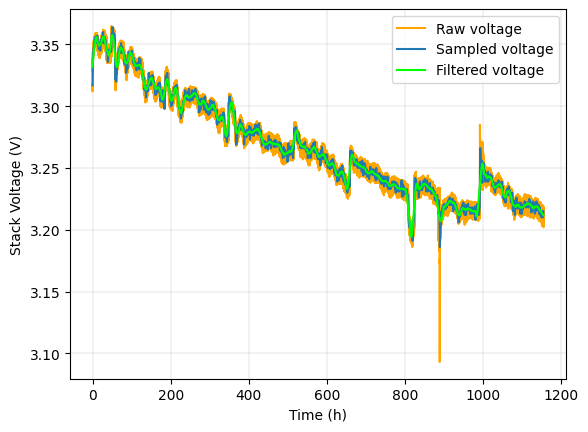

In [21]:
## PLOT FC1 RAW, FILTERED, AND SAMPLED VOLTAGES ##
plt.figure()
plt.plot(phm_dataset_1['Time (h)'], phm_dataset_1['Utot (V)'], 'orange', label = 'Raw voltage')
plt.plot(time_1, volt_1, 'tab:blue', label = 'Sampled voltage')
plt.plot(time_1, smoothed_df_1['Utot (V)'], 'lime', label = 'Filtered voltage')
plt.xlabel('Time (h)')
plt.ylabel('Stack Voltage (V)')
plt.legend(loc = 'upper right')
plt.grid(visible=True, which='major', color = 'darkgray', lw = 0.2)
# Download the figure
# plt.savefig('demo.png', transparent = True)
# from google.colab import files
# files.download("demo.png")

In [ ]:
## PLOT FC2 RAW, FILTERED, AND SAMPLED VOLTAGES ##
plt.figure()
#plt.plot(phm_dataset_2['Time (h)'], phm_dataset_2['Utot (V)'], 'orange', label = 'Raw voltage')
plt.plot(time_2, volt_2, 'tab:blue', label = 'Sampled voltage')
plt.plot(time_2, smoothed_df_2['Utot (V)'], 'lime', label = 'Filtered voltage')
plt.xlabel('Time (h)')
plt.ylabel('Stack Voltage (V)')
plt.legend(loc = 'upper right')
plt.grid(visible=True, which='major', color = 'darkgray', lw = 0.2)

# Model Evaluation

In [47]:
# Run to evaluate model performance

networks = Neural_Networks(x_train_s1, y_train_s1, x_valid_s1, y_valid_s1, x_test_s1, y_test_s1, volt_scaler_1)
# 定义 LSTM 模型的超参数
hidden_neurons = 50    # LSTM 隐藏层神经元个数
activator = 'tanh'     # 激活函数
drop_out = 0.2         # Dropout 防止过拟合
optimizer = 'adam'     # 选用 Adam 优化器

# 构建 LSTM 模型
lstm_model = networks.build_LSTM_model(hidden_neurons, activator, drop_out, optimizer)
# 训练 LSTM 模型
epochs = 20
batch_size = 72

history = lstm_model.fit(
    networks.x_train, networks.y_train,
    validation_data=(networks.x_valid, networks.y_valid),
    epochs=epochs, batch_size=batch_size, shuffle=False
)
# 评估 LSTM 模型
test_loss = lstm_model.evaluate(networks.x_test, networks.y_test)
print("Test Loss:", test_loss)

# 预测测试集数据
y_pred = lstm_model.predict(networks.x_test)

# 绘制训练和验证损失曲线
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curve')
plt.show()



# networks = Neural_Networks_2(x_train_s2, y_train_s2, x_valid_s2, y_valid_s2, x_test_s2, y_test_s2, volt_scaler_2)
# networks = Neural_Networks(x_train_s1, y_train_s1, x_valid_s2, y_valid_s2, x_test_s2, y_test_s2, volt_scaler_2)
# Evaluate RMSE, MAPE, R2arr_RMSE, arr_MAPE, arr_R2, arr_RUL, arr_RUL_RE, y_pred, y_true = networks.loop_model(1,2)

AttributeError: 'Sequential' object has no attribute 'reset_states'

#Hyperparameter Optimization

In [41]:
class optuna_search():
    """
    Class employing the Optuna Python package for hyperparameter optimization
    The cuDNN GPU accelerator is not applied to LSTM/GRU layers not meeting specified criteria (https://stackoverflow.com/a/68846093)
    """

    def __init__(self, x_train, y_train, x_valid, y_valid, x_test, y_test, scaler) -> None:
        self.neural_network = Neural_Networks(x_train, y_train, x_valid, y_valid, x_test, y_test, scaler)
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.scaler = scaler


    def build_deep_LSTM_model(self, trial):
        """
        Function to build LSTM models with arbitrary number of hidden layers.
        Definition changed each time a new model with arbitrary number of hidden layers is optimized.
        Used for pure LSTM and GRU models only
        """
        output_neurons = 1
        layers = list()
        optimizer =  self.create_optimizer(trial)
        n_layers = trial.suggest_int("n_hidden_layers", 1, 10)
        drop_out = trial.suggest_float('dropout', 0.01, 0.5)
        if n_layers > 1:
          layers = [keras.layers.LSTM(trial.suggest_int("n_units_L{}".format(_), 30, 100),
                                            input_shape = (self.x_train.shape[1], self.x_train.shape[2]), return_sequences = True) for _ in range(n_layers)]
        layers.append(keras.layers.LSTM(trial.suggest_int("n_units_L{}".format(n_layers), 30, 100),
                                        input_shape = (self.x_train.shape[1], self.x_train.shape[2]), dropout = drop_out))
        layers.append(keras.layers.Dense(output_neurons))
        deep_model = keras.Sequential(layers = layers)
        deep_model.reset_states()
        deep_model.compile(optimizer = optimizer, loss = 'mae')
        return deep_model


    def build_deep_GRU_model(self, trial):
        """
        Function to build GRU models with arbitrary number of hidden layers.
        """
        output_neurons = 1
        layers = list()
        optimizer =  self.create_optimizer(trial)
        n_layers = trial.suggest_int("n_hidden_layers", 1, 10)
        drop_out = trial.suggest_float('dropout', 0.01, 0.5)
        if n_layers > 1:
          layers = [keras.layers.GRU(trial.suggest_int("n_units_L{}".format(_), 30, 100),
                                            input_shape = (self.x_train.shape[1], self.x_train.shape[2]), return_sequences = True) for _ in range(n_layers)]
        layers.append(keras.layers.GRU(trial.suggest_int("n_units_L{}".format(n_layers), 30, 100),
                                        input_shape = (self.x_train.shape[1], self.x_train.shape[2]), dropout = drop_out))
        layers.append(keras.layers.Dense(output_neurons))
        deep_model = keras.Sequential(layers = layers)
        deep_model.reset_states()
        deep_model.compile(optimizer = optimizer, loss = 'mae')
        return deep_model


    def create_optimizer(self, trial):
        """
        Create optimizer with specific ranges for hyperparameter search.
        optimizer_selected: Optimizer type (RMSprop/Adam/SGD)
        trial.suggest_float() locates a hyperparameter sample in the search space using TPE for each trial
        """
        kwargs = {}
        optimizer_options = ['Adam', 'SGD', 'RMSprop']
        optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
        if optimizer_selected == "RMSprop":
            kwargs["learning_rate"] = trial.suggest_float(
                "rmsprop_learning_rate", 1e-5, 1e-1, log=True)
            kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
            kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
        elif optimizer_selected == "Adam":
            kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
        elif optimizer_selected == "SGD":
            kwargs["learning_rate"] = trial.suggest_float(
                "sgd_opt_learning_rate", 1e-5, 1e-1, log=True)
            kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-3, 99e-2, log=True)

        optimizer = getattr(tf.keras.optimizers.legacy, optimizer_selected)(**kwargs)
        return optimizer


    def objective_function(self, trial):
        """
        Returns objective function value to be optimized
        Uncomment the line corresponding to the hyperparameters to optimize.
        """
        #dropout = trial.suggest_float('dropout', 0.01, 0.5)
        #units = trial.suggest_int('units', 30, 110) #hidden_neurons
        #units_1 = trial.suggest_int('units_1', 30, 100) #hidden_neurons
        #activation = trial.suggest_categorical("activation", ['relu', 'tanh', 'softsign'])
        #activation_1 = trial.suggest_categorical("activation", ['relu', 'tanh', 'softsign'])
        #optimizer =  self.create_optimizer(trial)
        #filters = trial.suggest_int('filters', 30, 100) #filters for CNN
        #test_model = self.build_deep_LSTM_model(trial)
        test_model = self.build_deep_GRU_model(trial)
        self.neural_network.train_model(test_model)
        y_true, y_pred = self.neural_network.predict(test_model)
        return self.neural_network.evaluate_loss_function(y_true, y_pred)


    def optimize_study(self):
        """
        Configures the hyperparameter optimization settings.
        """
        from optuna.visualization import plot_optimization_history, plot_param_importances
        from optuna.importance import get_param_importances
        study = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(),
                                    pruner = optuna.pruners.HyperbandPruner())
        study.optimize(self.objective_function, n_trials = 500)
        plot_optimization_history(study).show()
        print(get_param_importances(study))
        return study.best_params, study.best_value


    def optimize(self):
        """
        Performs the optimization process.
        """
        best_params, best_values = self.optimize_study()
        print(f"Best params: {best_params}\n Best value: {best_values}")
        return self

In [40]:
# Run to optimize hyperparameters
param_optimizer = optuna_search(x_train_s1, y_train_s1, x_valid_s1, y_valid_s1, x_test_s1, y_test_s1, volt_scaler_1)
param_optimizer.optimize()

[I 2025-02-24 07:18:25,826] A new study created in memory with name: no-name-35b6594e-0aa7-4feb-851a-45a7aa6048a8
[W 2025-02-24 07:18:25,828] Trial 0 failed with parameters: {'optimizer': 'Adam', 'adam_learning_rate': 1.3604265603390061e-05} because of the following error: ImportError('`keras.optimizers.legacy` is not supported in Keras 3. When using `tf.keras`, to continue using a `tf.keras.optimizers.legacy` optimizer, you can install the `tf_keras` package (Keras 2) and set the environment variable `TF_USE_LEGACY_KERAS=True` to configure TensorFlow to use `tf_keras` when accessing `tf.keras`.').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-27-d59c93119780>", line 98, in objective_function
    test_model = self.build_deep_GRU_model(trial)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-i

ImportError: `keras.optimizers.legacy` is not supported in Keras 3. When using `tf.keras`, to continue using a `tf.keras.optimizers.legacy` optimizer, you can install the `tf_keras` package (Keras 2) and set the environment variable `TF_USE_LEGACY_KERAS=True` to configure TensorFlow to use `tf_keras` when accessing `tf.keras`.